Import necessary libraries

In [1]:
library(dplyr)
library(ggplot2)
library(caret)
library(class)
library(reshape2)
library(readr)
library(stringr)
library(boot)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: lattice



Load data. It was already prepared beforehand.

In [2]:
# Install and load the required package if not already installed
if (!requireNamespace("readr", quietly = TRUE)) {
  install.packages("readr")
}
library(readr)

# Read the CSV file into a data frame
trips <- read_csv("trips_import.csv")

# View the first few rows of the data frame
head(trips)

Rows: 4667 Columns: 29
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (2): store_and_fwd_flag, pickup_weekday
dbl  (19): VendorID, passenger_count, trip_distance, RatecodeID, PULocationI...
dttm  (2): tpep_pickup_datetime, tpep_dropoff_datetime
date  (4): file_date, eom_plus_1, pickup_date, dropoff_date
time  (2): pickup_time, dropoff_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,⋯,pickup_date,pickup_time,dropoff_date,dropoff_time,trip_duration,pickup_hour,pickup_weekday,PULocationID_encoded,DOLocationID_encoded,VendorID_encoded
<dbl>,<dttm>,<dttm>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,⋯,<date>,<time>,<date>,<time>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
1,2019-01-01 00:46:00,2019-01-01 00:53:00,1,1.5,1,N,151,239,1,⋯,2019-01-01,00:46:00,2019-01-01,00:53:00,420,0,Tuesday,11.16306,11.72387,13.60151
1,2019-01-01 00:59:00,2019-01-01 01:18:00,1,2.6,1,N,239,246,1,⋯,2019-01-01,00:59:00,2019-01-01,01:18:00,1140,0,Tuesday,11.45866,12.85057,13.60151
1,2019-01-01 00:21:00,2019-01-01 00:28:00,1,1.3,1,N,163,229,1,⋯,2019-01-01,00:21:00,2019-01-01,00:28:00,420,0,Tuesday,13.10380,11.41102,13.60151
1,2019-01-01 00:32:00,2019-01-01 00:45:00,1,3.7,1,N,229,7,1,⋯,2019-01-01,00:32:00,2019-01-01,00:45:00,780,0,Tuesday,12.54057,18.32217,13.60151
1,2019-01-01 00:57:00,2019-01-01 01:09:00,2,2.1,1,N,141,234,1,⋯,2019-01-01,00:57:00,2019-01-01,01:09:00,720,0,Tuesday,11.15727,11.23590,13.60151
1,2019-01-01 00:24:00,2019-01-01 00:47:00,2,2.8,1,N,246,162,1,⋯,2019-01-01,00:24:00,2019-01-01,00:47:00,1380,0,Tuesday,16.20216,10.98241,13.60151


Selection of columns that will be used for knn (continuous and catagorical). Added  transformation - fare per meter.

In [31]:
# Step 1: Select suitable columns and filter them
knn_columns <- c(
  'trip_distance', 'fare_amount', 'extra', 'mta_tax', 'tip_amount',
  'tolls_amount', 'improvement_surcharge', 'trip_duration',
  'pickup_hour', 'PULocationID_encoded', 'DOLocationID_encoded', 'VendorID_encoded'
)

knn_data <- trips[, knn_columns]

# Add fare per meter and make sure there's no division by 0 and NA values
knn_data$fare_per_meter <- ifelse(knn_data$trip_distance == 0, NA, knn_data$fare_amount / knn_data$trip_distance)
knn_data$fare_per_meter[is.na(knn_data$fare_per_meter)] <- 0

# Display the result to ensure that there is no division by zero
print(head(knn_data[, c('fare_amount', 'trip_distance', 'fare_per_meter')]))

# A tibble: 6 × 3
  fare_amount trip_distance fare_per_meter
        <dbl>         <dbl>          <dbl>
1         7             1.5           4.67
2        14             2.6           5.38
3         6.5           1.3           5   
4        13.5           3.7           3.65
5        10             2.1           4.76
6        15             2.8           5.36


Categorize trip duration into 5 categories

In [4]:
# Step 2: categorize trip duration into 5 categories based on quantiles

knn_data$trip_duration_class <- cut(
  knn_data$trip_duration,
  breaks = quantile(knn_data$trip_duration, probs = c(0, 0.2, 0.4, 0.6, 0.8, 1)),
  labels = c(0, 1, 2, 3, 4),
  include.lowest = TRUE
)

print(table(cut(knn_data$trip_duration, breaks = quantile(knn_data$trip_duration, probs = c(0, 0.2, 0.4, 0.6, 0.8, 1)), include.lowest = TRUE)))


            [0,300]           (300,540]           (540,720]      (720,1.08e+03] 
                972                1147                 711                 976 
(1.08e+03,2.22e+03] 
                861 


Filter out strong correlations and constant columns (they don't give anything useful)

In [32]:
numeric_cols <- knn_data[, sapply(knn_data, is.numeric) & names(knn_data) != "trip_duration"]

# Calculate the correlation matrix
corr_matrix <- cor(numeric_cols)
corr_matrix_melt <- melt(corr_matrix) # Melt the correlation matrix

# Remove highly correlated features
high_corr_features <- corr_matrix_melt %>%
  filter(abs(value) > 0.8 & Var1 != Var2)

# Drop the highly correlated features from the original data frame
knn_data_cleaned <- knn_data[, !names(knn_data) %in% high_corr_features$Var1]

Warning message in cor(numeric_cols):
“the standard deviation is zero”


In [7]:
high_corr_features

Var1,Var2,value
<fct>,<fct>,<dbl>
fare_amount,trip_distance,0.9197992
trip_distance,fare_amount,0.9197992


In [33]:
# Check for constant columns
constant_columns <- names(knn_data_cleaned)[sapply(knn_data_cleaned, function(x) length(unique(x)) == 1)]
print(paste("Constant columns:", paste(constant_columns, collapse = ", ")))

# Remove constant columns from the data
knn_data_cleaned_2 <- knn_data_cleaned[, !names(knn_data_cleaned) %in% constant_columns]

[1] "Constant columns: extra, mta_tax, tolls_amount, improvement_surcharge"


Draw correlation matrix

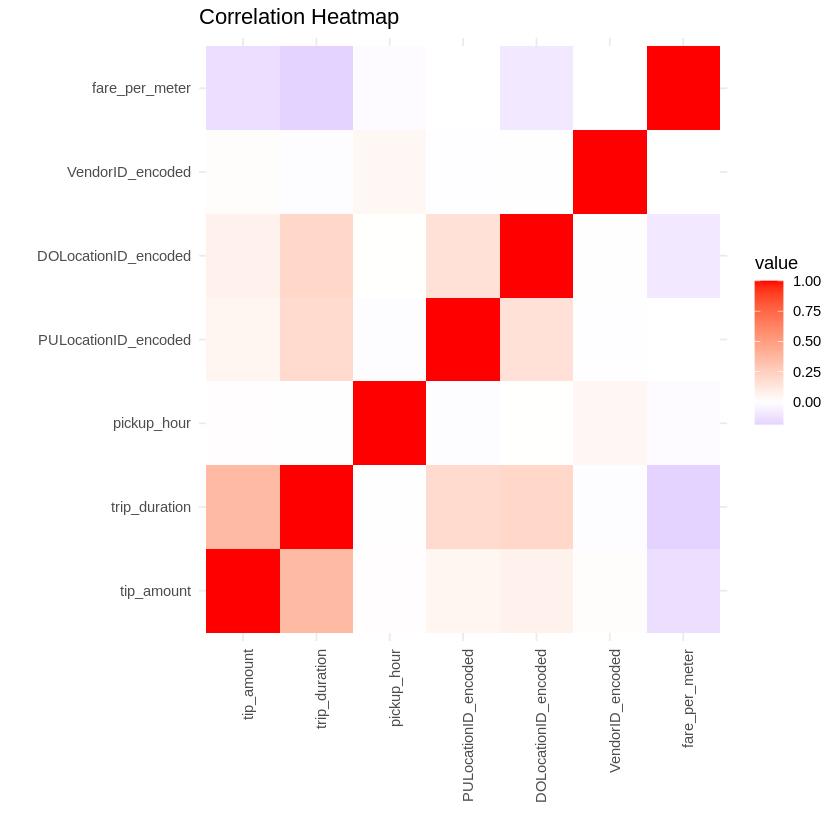

In [34]:
numeric_cols <- knn_data_cleaned_2[, sapply(knn_data_cleaned_2, is.numeric)]

corr_matrix <- cor(numeric_cols)

# Plot the heatmap to visualize the correlations
corr_matrix_melt <- melt(corr_matrix)
ggplot(corr_matrix_melt, aes(x = Var1, y = Var2, fill = value)) +
  geom_tile() +
  scale_fill_gradient2(low = "blue", mid = "white", high = "red") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
  labs(title = "Correlation Heatmap", x = "", y = "")



In [35]:
# Drop the 'tip_amount' column because it is higly correlated with trip_duration and also it is paid after the trip so wouldn't  be useful for modelling
knn_data_cleaned <- knn_data_cleaned[, !names(knn_data_cleaned) %in% "tip_amount"]


Assign dependent and independent variables

In [22]:
# Prepare Features and Target Variable
X <- knn_data_cleaned_2[, !names(knn_data_cleaned_2) %in% c("trip_duration", "trip_duration_class")]
y <- knn_data_cleaned_2$trip_duration_class


Scale

In [23]:
# Scale the features
X_scaled <- scale(X)

Split the data into training (80%) and testing sets (20% of data)

In [24]:
set.seed(42)
train_index <- sample(nrow(X_scaled), 0.8*nrow(X_scaled))
X_train <- X_scaled[train_index, ]
X_test <- X_scaled[-train_index, ]
y_train <- y[train_index]
y_test <- y[-train_index]

Calculate misclassification error for different k values in order to find optimal k. Find optimal k value by choosing one with lowest misclassifiaction errors. Visualize errors.

In [36]:
error_rate <- numeric()
k_range <- 1:30  # Try k from 1 to 30
for (k in k_range) {
  # Create a KNN model with k neighbors
  y_pred_k <- knn(train = X_train, test = X_test, cl = y_train, k = k)
  # Calculate misclassification error
  error <- mean(y_pred_k != y_test)
  error_rate <- c(error_rate, error)   # Append the error to the error rate vector
}

[1] "The optimal k value is: 16"


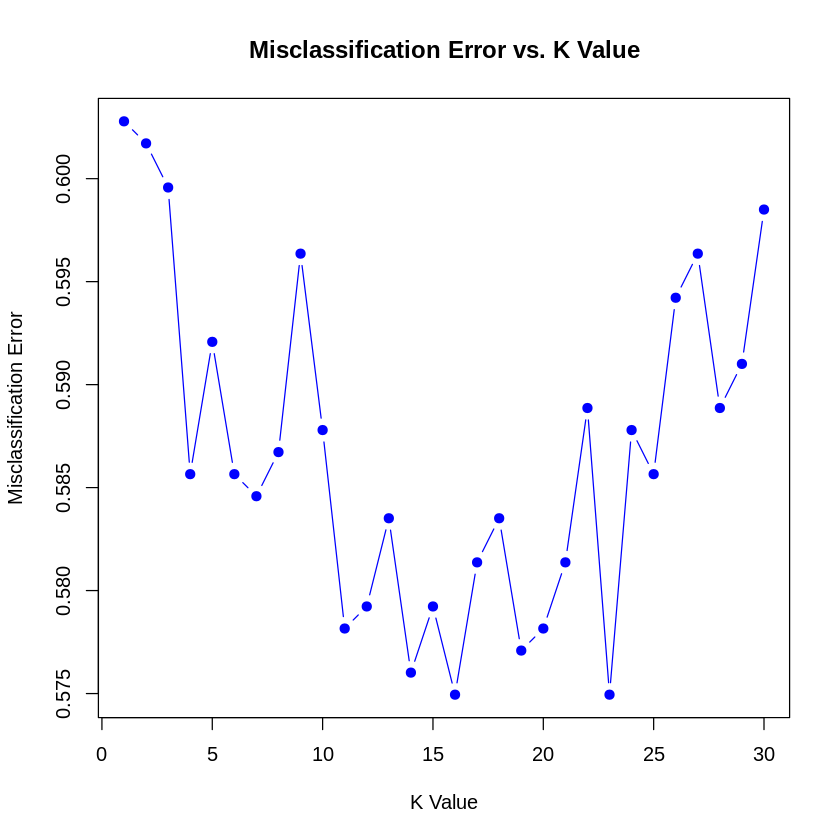

In [37]:
# Find the optimal k value
optimal_k <- k_range[which.min(error_rate)]
print(paste("The optimal k value is:", optimal_k))

# Plot the misclassification error
plot(k_range, error_rate, type = "b", pch = 19, col = "blue",
     main = "Misclassification Error vs. K Value",
     xlab = "K Value", ylab = "Misclassification Error")

Fit KNN with the optimal k

In [38]:
knn <- knn(train = X_train, test = X_train, cl = y_train, k = optimal_k, prob = TRUE)

Confusion Matrix and Statistics

          Reference
Prediction   0   1   2   3   4
         0 112  55  24  13   9
         1  68 104  71  48  14
         2  10  13  19  18   9
         3   8  33  35  59  38
         4   6  12  14  45  97

Overall Statistics
                                         
               Accuracy : 0.4186         
                 95% CI : (0.3868, 0.451)
    No Information Rate : 0.2323         
    P-Value [Acc > NIR] : < 2.2e-16      
                                         
                  Kappa : 0.2658         
                                         
 Mcnemar's Test P-Value : 5.507e-09      

Statistics by Class:

                     Class: 0 Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.5490   0.4793  0.11656  0.32240   0.5808
Specificity            0.8616   0.7197  0.93515  0.84820   0.8996
Pos Pred Value         0.5258   0.3410  0.27536  0.34104   0.5575
Neg Pred Value         0.8724   0.8203  0.83353  0.83706   0.9079
Prevalence

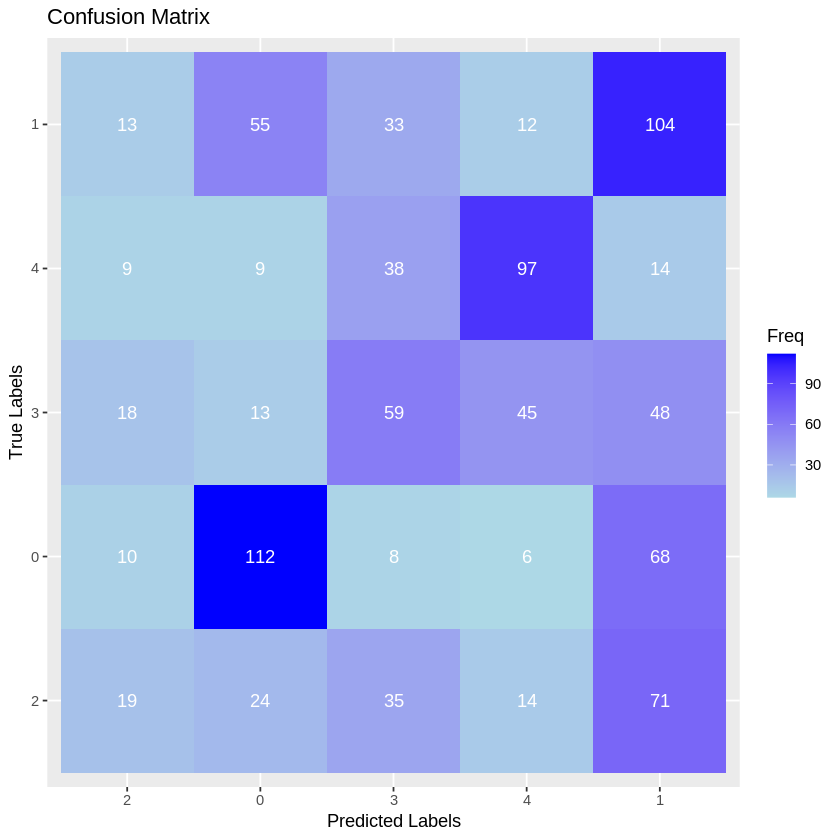

In [29]:
# Predict on the test data
y_pred <- knn(train = X_train, test = X_test, cl = y_train, k = optimal_k)

# Confusion Matrix
conf_matrix <- confusionMatrix(data = y_pred, reference = y_test)

# Display confusion matrix
conf_matrix_df <- as.data.frame(conf_matrix$table)
conf_matrix_df$Prediction <- factor(conf_matrix_df$Prediction, levels = unique(y_test))
conf_matrix_df$Reference <- factor(conf_matrix_df$Reference, levels = unique(y_test))
ggplot(conf_matrix_df, aes(x = Prediction, y = Reference, fill = Freq)) +
  geom_tile() +
  geom_text(aes(label = Freq), color = "white") +
  scale_fill_gradient(low = "lightblue", high = "blue") +
  labs(title = "Confusion Matrix", x = "Predicted Labels", y = "True Labels")

# Classification Report
print(conf_matrix)

In [30]:


knn_boot <- function(data, indices) {
  boot_data <- data[indices, ]

  # Split the bootstrap sample into training and testing sets
  set.seed(123)
  train_idx <- sample(nrow(boot_data), 0.7*nrow(boot_data))
  train_data <- boot_data[train_idx, ]
  test_data <- boot_data[-train_idx, ]

  # Fit the KNN model to the bootstrap training data
  knn_boot <- knn(train = train_data[, -ncol(train_data)], test = test_data[, -ncol(test_data)], cl = train_data[, ncol(train_data)], k = optimal_k, prob = TRUE)

  # Calculate the accuracy
  accuracy_boot <- sum(knn_boot == test_data[, ncol(test_data)]) / nrow(test_data)

  return(accuracy_boot)
}

=
set.seed(123)
boot_results <- boot(data = cbind(X_train, y_train), statistic = knn_boot, R = 1000)

print("Bootstrap results:")
print(boot_results)

# Calculate the average accuracy
avg_accuracy <- mean(boot_results$t)
print(paste("Average accuracy:", avg_accuracy))

# Calculate the 95% confidence interval
ci <- quantile(boot_results$t, probs = c(0.025, 0.975))
print(paste("95% confidence interval:", ci))

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Attaching package: ‘boot’


The following object is masked from ‘package:lattice’:

    melanoma





ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = cbind(X_train, y_train), statistic = knn_boot, R = 1000)


Bootstrap Statistics :
     original     bias    std. error
t1* 0.4169643 0.05920625  0.01651053
[1] "Average accuracy: 0.476170535714286"
[1] "95% confidence interval: 0.447299107142857"
[2] "95% confidence interval: 0.509821428571429"
